In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyStochastic = MdpKernel()
mdpPolicyStochastic.load_policy(mdpKernelParams, policyMode="stochastic")
mdpPolicyDeterministic = MdpKernel()
mdpPolicyDeterministic.load_policy(mdpKernelParams, policyMode="deterministic")

# ==== Prepare Simulator====
num_windows = 5000
obvMode = "predicted" # "perfect" or "predicted"
policySimulator = PolicySimulator(mdpPolicyDeterministic, env)
simResultDeterministic = policySimulator.runSimulation(mdpPolicyDeterministic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultDeterministic['uRecord'], 
    simResultDeterministic['actionsRecord'], 
    simResultDeterministic['rewardRecord'], 
    simResultDeterministic['uNextRecord']
)
'''
policySimulator = PolicySimulator(mdpPolicyStochastic, env)
simResultStochastic = policySimulator.runSimulation(mdpPolicyStochastic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
uRecord = np.concatenate((simResultStochastic['uRecord'], simResultDeterministic['uRecord']))
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultStochastic['uRecord'] + simResultDeterministic['uRecord'], 
    simResultStochastic['actionsRecord'] + simResultDeterministic['actionsRecord'], 
    simResultStochastic['rewardRecord'] + simResultDeterministic['rewardRecord'], 
    simResultStochastic['uNextRecord'] + simResultDeterministic['uNextRecord']
)
'''


Simulation Progress: 100%|██████████| 5000/5000 [00:09<00:00, 532.72it/s, avg reward=0.003893]


'\npolicySimulator = PolicySimulator(mdpPolicyStochastic, env)\nsimResultStochastic = policySimulator.runSimulation(mdpPolicyStochastic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")\nuRecord = np.concatenate((simResultStochastic[\'uRecord\'], simResultDeterministic[\'uRecord\']))\n(uRecord, actionsRecord, rewardRecord, uNextRecord) = (\n    simResultStochastic[\'uRecord\'] + simResultDeterministic[\'uRecord\'], \n    simResultStochastic[\'actionsRecord\'] + simResultDeterministic[\'actionsRecord\'], \n    simResultStochastic[\'rewardRecord\'] + simResultDeterministic[\'rewardRecord\'], \n    simResultStochastic[\'uNextRecord\'] + simResultDeterministic[\'uNextRecord\']\n)\n'

In [8]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 5e-5,
    'eta': 1e-3,
    'dropout_p': 0.05,
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env,
    clonePolicy=True,
    epochs=1000, 
    batch_size=256)

Evaluation windows: 100%|██████████| 500/500 [00:03<00:00, 149.72it/s]                                        


Epoch  100/1000  Avg Ld=0.137398  Avg Lq=-0.001423  Avg loss_critic=0.063642  Test packet loss=0.0081


Evaluation windows: 100%|██████████| 500/500 [00:03<00:00, 147.54it/s]                                        


Epoch  200/1000  Avg Ld=0.036084  Avg Lq=-0.001000  Avg loss_critic=0.000079  Test packet loss=0.0065


Evaluation windows: 100%|██████████| 500/500 [00:03<00:00, 148.82it/s]                                        


Epoch  300/1000  Avg Ld=0.024085  Avg Lq=-0.001000  Avg loss_critic=0.000072  Test packet loss=0.0057


Evaluation windows: 100%|██████████| 500/500 [00:03<00:00, 149.62it/s]                                        


Epoch  400/1000  Avg Ld=0.017277  Avg Lq=-0.001000  Avg loss_critic=0.000067  Test packet loss=0.0059


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 110.42it/s]                                        


Epoch  500/1000  Avg Ld=0.014921  Avg Lq=-0.001000  Avg loss_critic=0.000064  Test packet loss=0.0083


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 106.30it/s]                                        


Epoch  600/1000  Avg Ld=0.013434  Avg Lq=-0.001000  Avg loss_critic=0.000063  Test packet loss=0.0065


Evaluation windows: 100%|██████████| 500/500 [00:05<00:00, 84.32it/s]                                         


Epoch  700/1000  Avg Ld=0.012126  Avg Lq=-0.001000  Avg loss_critic=0.000064  Test packet loss=0.0048


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 104.92it/s]                                        


Epoch  800/1000  Avg Ld=0.011522  Avg Lq=-0.001000  Avg loss_critic=0.000061  Test packet loss=0.0066


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 110.50it/s]                                        


Epoch  900/1000  Avg Ld=0.010478  Avg Lq=-0.001000  Avg loss_critic=0.000061  Test packet loss=0.0055


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 112.33it/s]                                         

Epoch 1000/1000  Avg Ld=0.010229  Avg Lq=-0.001000  Avg loss_critic=0.000061  Test packet loss=0.0061


In [10]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl


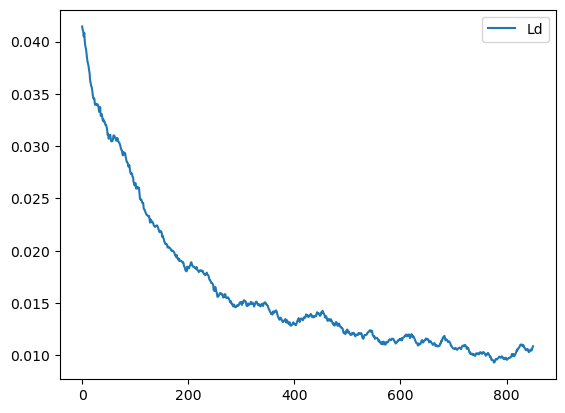

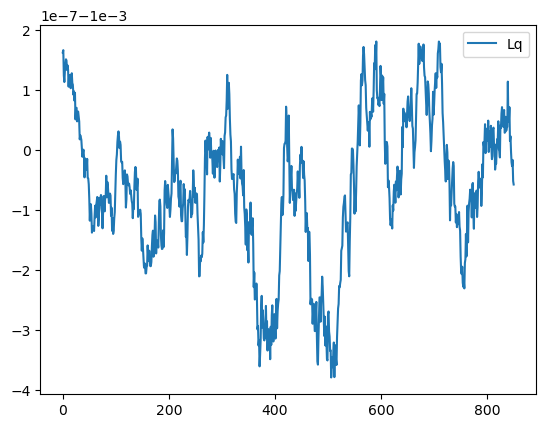

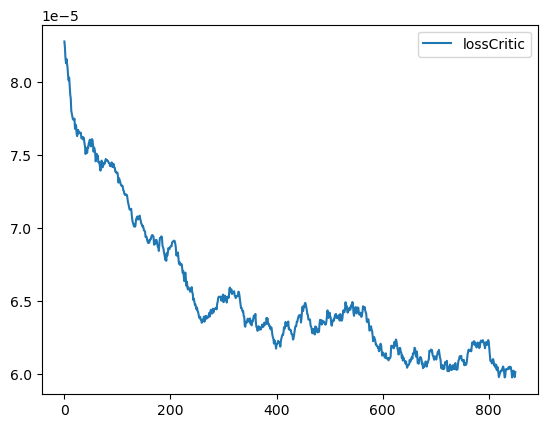

In [11]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -900
window_size = 50
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()